In [1]:
import numpy as np
import pandas as pd
from Autoencoder import Autoencoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, CSVLogger , ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('PSV_data.csv')
df_nums = df.select_dtypes(include='number')

In [3]:
df_nums.head()

,distance_a,distance_b1,distance_b2,cubic,ortho,eleneg_a,eleneg_b1,eleneg_b2,eleneg_x,hoe_a,...,rp_a,rp_b1,rp_b2,rp_x,rs_a,rs_b1,rs_b2,rs_x,ind_gap,heat_of_formation
0,3.870604,2.912570,2.555464,1,0,0.79,1.93,1.61,2.96,-2.0862,...,2.6,1.33,0.905,0.62,1.71,1.045,0.77,0.58,1.0274,-1.240558
1,3.925597,2.858240,2.692150,1,0,0.79,1.93,2.18,2.96,-2.0862,...,2.6,1.33,0.745,0.62,1.71,1.045,0.67,0.58,0.7810,-1.012833
2,4.059806,2.856817,2.884582,1,0,0.79,1.93,2.02,2.96,-2.0862,...,2.6,1.33,1.077,0.62,1.71,1.045,0.92,0.58,1.1399,-1.145090
3,3.887140,2.881822,2.612114,1,0,0.79,1.93,1.81,2.96,-2.0862,...,2.6,1.33,0.935,0.62,1.71,1.045,0.76,0.58,0.0000,-1.112540
4,3.966402,2.870028,2.738541,1,0,0.79,1.93,1.78,2.96,-2.0862,...,2.6,1.33,1.110,0.62,1.71,1.045,0.94,0.58,0.1818,-1.162859


In [4]:
# removing the redundant columns and dependent variables
df_nums = df_nums.drop(['ortho','ind_gap','heat_of_formation'], axis=1)

In [5]:
X = df_nums.iloc[:,:].values

In [6]:
# scaling the features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)

In [7]:
def scheduler(epoch, lr):
    if epoch<25:
        return lr
    elif epoch >=25 and epoch < 50:
        return lr*0.99
    elif epoch >=50 and epoch <75:
        return lr*0.98
    else:
        return lr*0.80

In [8]:
lr_scheduler = LearningRateScheduler(
    scheduler,
    verbose=1
)

In [9]:
rlr = ReduceLROnPlateau(
    monitor='loss',
    patience=3,
    factor=0.9
)

In [10]:
log_csv = CSVLogger(
    'autoencoder_logs.csv',
    separator = ',',
    append=False
)

In [11]:
autoencoder = Autoencoder(latent_dim = 10, out_dims=32)
autoencoder.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss='mean_squared_error')

In [12]:
autoencoder.fit(X_scaled, X_scaled, epochs=100,batch_size=5,shuffle=True,callbacks=[rlr,log_csv])

Epoch 1/100
108/108 [==============================] - 1s 2ms/step - loss: 0.1242 - lr: 0.0200
Epoch 2/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0901 - lr: 0.0200
Epoch 3/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0782 - lr: 0.0200
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0610 - lr: 0.0200
Epoch 5/100
108/108 [==============================] - 0s 2ms/step - loss: 0.0567 - lr: 0.0200
Epoch 6/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0512 - lr: 0.0200
Epoch 7/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0468 - lr: 0.0200
Epoch 8/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0484 - lr: 0.0200
Epoch 9/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0513 - lr: 0.0200
Epoch 10/100
108/108 [==============================] - 0s 3ms/step - loss: 0.0566 - lr: 0.0200
Epoch 11/100
108/108 [===========================

In [13]:
mse = tf.keras.losses.MeanSquaredError()
X_pred = autoencoder.call(X_scaled)
error = mse(X_pred,X_scaled).numpy()
print(f'Error of the model: {error*100:.2f} %')

Error of the model: 1.03 %


In [14]:
logs = pd.read_csv('autoencoder_logs.csv')
loss = logs['loss'].values
epochs = range(0,100)

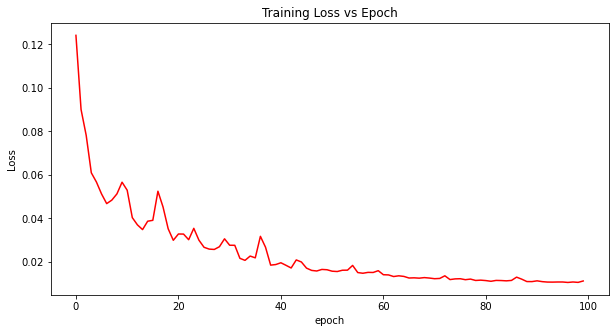

In [15]:
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color='red')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.show()

### Extracting the  features

In [16]:
encoded_features = np.array(autoencoder.encoder(X_scaled))

In [17]:
df_new = pd.DataFrame(encoded_features, columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])

In [18]:
df_new.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,-0.944244,-0.467843,-0.250634,-0.607917,0.722437,2.718357,1.390860,0.095709,-0.376503,-0.381374
1,-0.184422,-0.263323,-0.406619,1.421094,1.284893,3.853995,1.308007,-0.123640,1.368393,0.935994
2,-0.381459,-0.321316,-0.360481,0.190600,1.159082,3.447642,1.226776,-0.085541,0.499673,0.133785
3,-0.791677,-0.419213,-0.270855,-0.446005,0.817097,2.801008,1.504990,-0.020920,-0.254898,-0.273302
4,-0.785569,-0.452266,-0.316529,-0.389248,0.983658,3.238737,0.938708,0.085265,-0.219014,-0.267498
5,-0.298216,-0.293468,-0.372609,0.674147,1.181730,3.559220,1.301948,-0.104680,0.844347,0.472531
6,-1.090993,-0.436903,-0.027316,-0.730014,-0.254356,2.922050,1.484697,0.668205,-0.545271,-0.230886
7,-0.201218,-0.236212,-0.325626,1.477631,0.465371,4.083724,1.383063,-0.082988,1.223730,1.462274
8,-0.398914,-0.304898,-0.297773,0.251982,0.490377,3.694568,1.197765,-0.044571,0.385097,0.562741
9,-0.877619,-0.400119,-0.124019,-0.506610,-0.107306,3.016967,1.446535,0.316221,-0.354654,-0.157876


In [19]:
y_df = df[['ind_gap','heat_of_formation']]
data_final = pd.concat([df_new,y_df],axis=1)

In [20]:
data_final.to_csv('../deeplearningModel/encoded_dataset.csv')

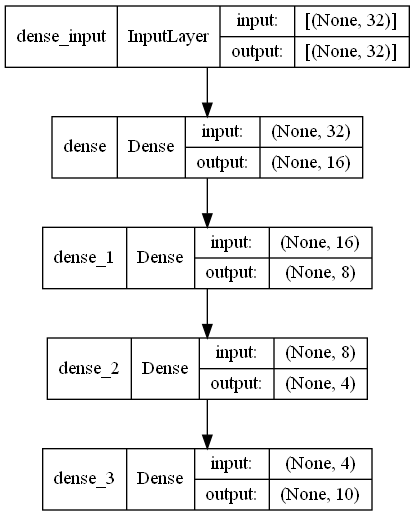

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder.encoder, to_file='encoder.png',show_shapes=True)

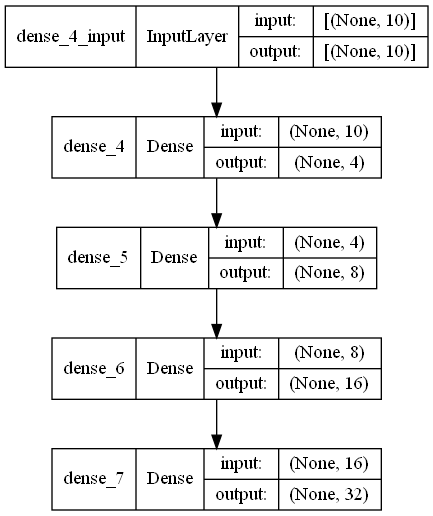

In [22]:
plot_model(autoencoder.decoder, to_file='decoder.png',show_shapes=True)